In [18]:
import glob
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.optimize import curve_fit
from scipy.optimize import leastsq

In [19]:
# pathの取得
def get_datapath(root_dir):
    target_csv_path = osp.join(root_dir, '*.csv')
    csv_list = [path for path in glob.glob(target_csv_path)]
    print(csv_list)
    return csv_list


def import_data(path):
    dataset = pd.read_csv(path, header=None).to_numpy()
    return dataset


In [20]:
def interporate(time_rss_list):
    new_data = []
    T_s = 1/17.78
    prev_time = None
    prev_illu = -1
    threthhold = 1.0*10**8
    for data in time_rss_list:
        time = data[0]
        illu = data[1]
        if prev_time and time - prev_time > threthhold:
            times = (time-prev_time)//(10**9/18)
            for j in range(int(times)-1):
                new_data.append((prev_time+(j+1)*10**9*T_s, prev_illu))
        new_data.append((time, illu))
        prev_time = time
        prev_illu = illu
    new_data = np.array(new_data)
    return new_data


def FFT(wave):
    return np.abs(np.fft.fft(wave))


def distance(point1, point2):
    d = np.sqrt((point1[0]-point2[0])**2+(point1[1] -
                point2[1])**2+(point1[2]-point2[2])**2)
    return d


In [21]:
path = get_datapath('./data/csv/2021-12-20/train')
data_list = [import_data(file) for file in path]

complemented_data_list = [interporate(data) for data in data_list]


['./data/csv/2021-12-20/train\\2021-12-20-18-14-40-377.csv', './data/csv/2021-12-20/train\\2021-12-20-18-17-42-599.csv', './data/csv/2021-12-20/train\\2021-12-20-18-20-56-691.csv', './data/csv/2021-12-20/train\\2021-12-20-18-23-45-161.csv', './data/csv/2021-12-20/train\\2021-12-20-18-26-35-355.csv', './data/csv/2021-12-20/train\\2021-12-20-18-29-16-799.csv']


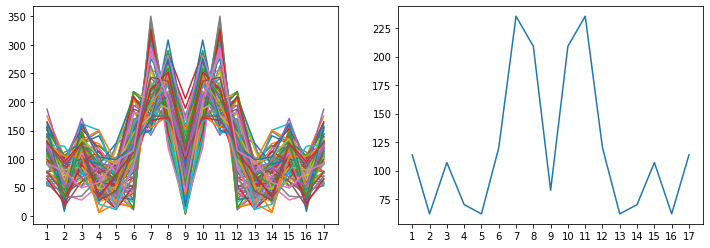

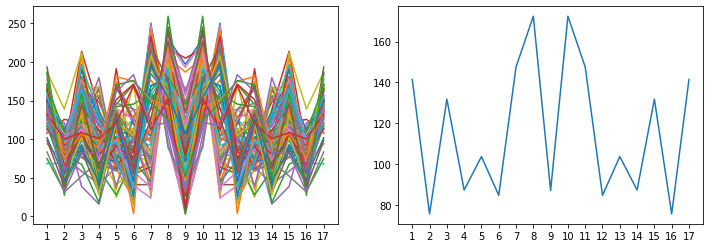

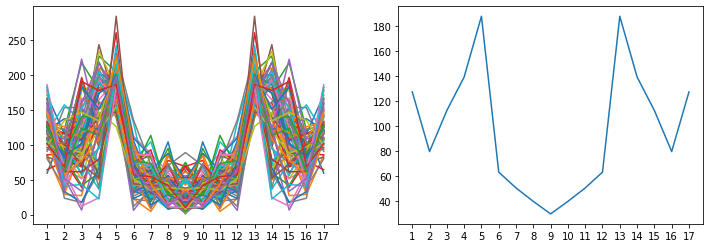

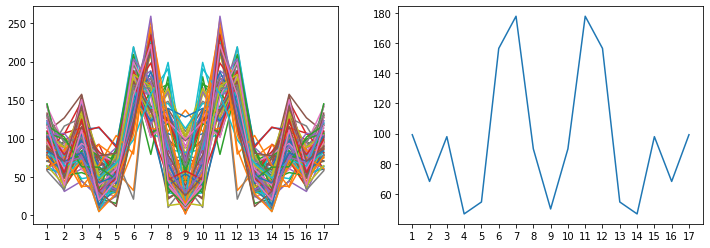

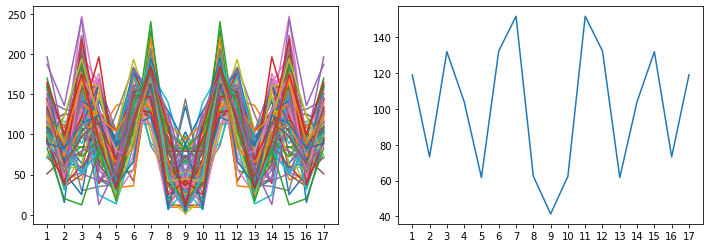

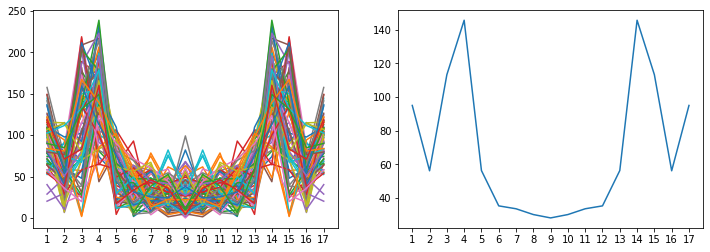

In [22]:
x = np.arange(1, 18)
illus_list = [data[:, 1] for data in complemented_data_list]
specs_list = [[FFT(illus[18*i:(18*i)+18]) for i in range(30, len(illus) // 18)]
              for illus in illus_list]
specs_mean_list = np.array([np.mean(specs, axis=0) for specs in specs_list])

for specs, mean in zip(specs_list, specs_mean_list):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for spec in specs:
        axes[0].plot(x, spec[1:])
    axes[1].plot(x, mean[1:])
    for ax in axes:
        ax.set_xticks(x)
        ax.set_xticklabels(x)


In [23]:
# 実験環境の定数をここで定義する
# LEDの座標
LED_POSITIONS = [[1.0, 1.0, 2.24], [2.0, 1.0, 2.24],
                 [1.0, 2.0, 2.24], [2.0, 2.0, 2.24]]
# 使用する周波数
FREQUENCIES = [98.8, 99.8, 101.7, 102.7]
# ALSのサンプリング周波数
SAMPLING_FREQENCY = 17.78
# 使用する周波数ピークの位置
PEAK_POSITIONS = [10, 11, 13, 14]
# フィッティングの座標
FITTING_POSITIONS = [[1.25, 1.0, 1.03], [1.25, 1.5, 1.03], [1.25, 2.0, 1.03],
                     [1.75, 1.0, 1.03], [1.75, 1.5, 1.03], [1.75, 2.0, 1.03]]


In [24]:
class Led():
    sampling_frequency = SAMPLING_FREQENCY

    def __init__(self, position, frequency, peak_pos) -> None:
        self.position = position
        self.frequency = frequency
        self.peak_pos = peak_pos
        self.train_distances = []
        self.train_rss_list = []
        self.popt = [0, 0]
        self.reciever_height = 0
        self.test_rss_list = []

    def fitting(self, reciever_height):
        self.reciever_height = reciever_height

        def theoreticalValue(x, a, b):
            certain = np.abs(np.sin(self.frequency*np.pi/self.sampling_frequency)/(
                self.frequency*np.pi/self.sampling_frequency))*((self.position[2]-self.reciever_height)**(0.82+5.35))
            f = a*np.sin(b*np.pi)*certain/x**(0.82+5.35+2)
            return f
        self.popt, self.pconv = curve_fit(
            theoreticalValue, self.train_distances, self.train_rss_list, bounds=((0, 0), (100000, 2)))

    def distance_quality(self, x):
        certain = np.abs(np.sin(self.frequency*np.pi/self.sampling_frequency)/(
            self.frequency*np.pi/self.sampling_frequency))*((self.position[2]-self.reciever_height)**(0.82+5.35))
        f = self.popt[0]*np.sin(self.popt[1]*np.pi)*certain/x**(0.82+5.35+2)
        return f

    def get_distance(self, rss):
        A = 1/(0.82+5.35+2)
        certain = np.abs(np.sin(self.frequency*np.pi/self.sampling_frequency)/(
            self.frequency*np.pi/self.sampling_frequency))*((self.position[2]-self.reciever_height)**(0.82+5.35))
        dist = (self.popt[0]*np.sin(self.popt[1]*np.pi)*certain/rss)**A
        return dist


In [25]:
led_list = [Led(led_pos, led_freq, peak_pos)
            for (led_pos, led_freq, peak_pos) in zip(LED_POSITIONS, FREQUENCIES, PEAK_POSITIONS)]
print(led_list[0].position)


[1.0, 1.0, 2.24]


In [26]:
for led in led_list:
    led.train_distances = [distance(led.position, fit)
                           for fit in FITTING_POSITIONS]
    led.train_rss_list = specs_mean_list[:, led.peak_pos].T
    led.fitting(FITTING_POSITIONS[0][2])


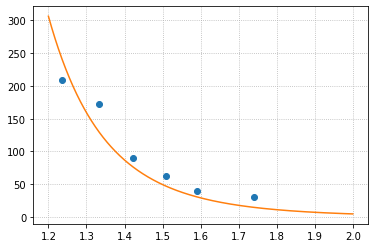

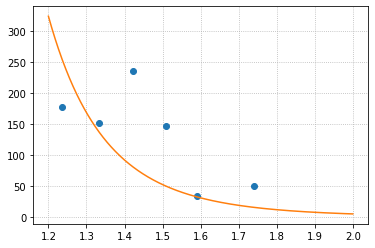

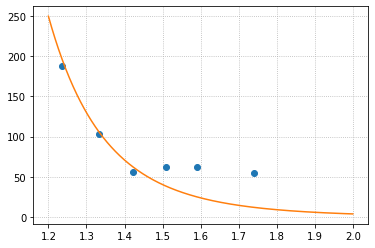

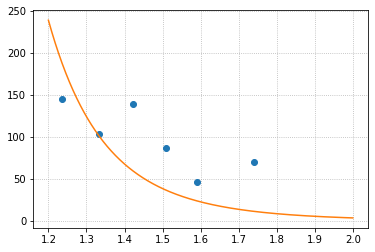

In [27]:
x = np.linspace(1.2, 2.0, 1000)
for led in led_list:
    plt.plot(led.train_distances, led.train_rss_list, 'o')
    plt.plot(x, led.distance_quality(x))
    plt.grid(linestyle='dotted')
    plt.show()


In [28]:
# 測位点の正解座標
TEST_POSITIONS = [[1.25, 1.25, 1.03], [1.25, 1.75, 1.03],
                  [1.75, 1.25, 1.03], [1.75, 1.75, 1.03]]


In [29]:
# 測位用のデータから各LEDに対応する光の強度を取得する
test_data_list = [import_data(file) for file in get_datapath('./data/csv/2021-12-20/test')]
complemented_test_data_list = [interporate(data) for data in test_data_list]
test_illus_list = [data[:, 1] for data in complemented_test_data_list]
test_specs_list = [[FFT(illus[18*i:(18*i)+18]) for i in range(30, len(illus) // 18)]
                   for illus in test_illus_list]
test_specs_mean_list = np.array(
    [np.mean(specs, axis=0) for specs in test_specs_list])


['./data/csv/2021-12-20/test\\2021-12-20-18-32-19-261.csv', './data/csv/2021-12-20/test\\2021-12-20-18-35-22-724.csv', './data/csv/2021-12-20/test\\2021-12-20-18-38-16-896.csv', './data/csv/2021-12-20/test\\2021-12-20-18-41-42-200.csv']


In [30]:
for led in led_list:
    led.test_rss_list = test_specs_mean_list[:, led.peak_pos].T
estimated_distances = np.array(
    [led.get_distance(led.test_rss_list) for led in led_list]).T
print(estimated_distances)


[[1.252228   1.26392956 1.38000629 1.35998272]
 [1.37912504 1.40492691 1.28118417 1.32107821]
 [1.38635962 1.27291042 1.40896861 1.37284427]
 [1.5310413  1.40932714 1.45334014 1.30978191]]


In [31]:
def fitFunc(est_pos, est_dist, led_pos):
    residual = est_dist - \
        np.array([np.sqrt((est_pos[0]-led[0])**2+(est_pos[1]-led[1])**2+(TEST_POSITIONS[0][2]-led[2])**2)
                 for led in led_pos])
    return residual


initial_val = np.array([1.5, 1.5])
est_pos_list = np.array([leastsq(fitFunc, initial_val, args=(
    point, LED_POSITIONS))[0] for point in estimated_distances])
print(est_pos_list)


[[1.50360872 1.3915552 ]
 [1.46399467 1.59920576]
 [1.58671824 1.42864657]
 [1.6954609  1.63065329]]


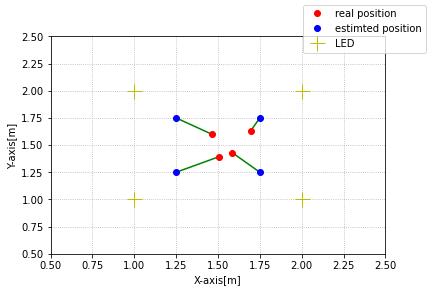

In [32]:
TEST_POSITIONS = np.array(TEST_POSITIONS)
LED_POSITIONS = np.array(LED_POSITIONS)

lines = [[sp, ep] for sp, ep in zip(est_pos_list, TEST_POSITIONS[:,:2])]
colors = ["g"]
lc = LineCollection(lines, colors=colors)

fig, ax = plt.subplots()
ax.plot(est_pos_list[:, 0], est_pos_list[:, 1],
        "ro", label="real position")
ax.plot(TEST_POSITIONS[:, 0], TEST_POSITIONS[:, 1],
        "bo", label="estimted position")
ax.plot(LED_POSITIONS[:, 0], LED_POSITIONS[:, 1],
        "y+", label="LED", markersize=15,)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0.5, 2.5)
ax.set_xlabel("X-axis[m]")
ax.set_ylabel("Y-axis[m]")
fig.legend()
ax.grid(linestyle='dotted')
ax.add_collection(lc)


In [33]:
error_list = [np.sqrt((est_pos[0]-test_pos[0])**2+(est_pos[1]-test_pos[1])**2)
              for (est_pos, test_pos) in zip(est_pos_list, TEST_POSITIONS)]
percentile_error = np.percentile(error_list, 90)
print(error_list)
print(percentile_error)


[0.29043976753488737, 0.2617873577985842, 0.24202382231130107, 0.13121795254415236]
0.2818440446139964


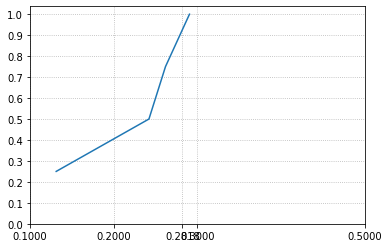

In [34]:
jjj = []
for j in range(len(error_list)):
    jjj.append((j+1)/len(error_list))
plt.plot(np.sort(error_list), jjj)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0.1, 0.2, 0.3, 0.5, percentile_error])
plt.grid(linestyle='dotted')
